## Libraries Import

In [1]:
import os
import re
import time
import logging
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer

## Neo4j Connection Setup

In [2]:
uri = "Create your credentials"
username = ""
password = ""

## Connection Delay and Init Driver

In [3]:
print("⏳ Waiting 60 seconds before connecting to Neo4j...")
time.sleep(60)
print("🚀 Attempting to connect to Neo4j...")

driver = None

⏳ Waiting 60 seconds before connecting to Neo4j...
🚀 Attempting to connect to Neo4j...


## Initialize Neo4j driver

✅ Connected to Neo4j!


INFO:root:🧠 Extracted 427 filtered triples.


🔗 ('the dursleys', 'tolerate', 'harry')
🔗 ('the dursleys', 'bully', 'harry')
🔗 ('dudley', 'tolerate', 'harry')
🔗 ('dudley', 'bully', 'harry')
🔗 ('dudley', 'tolerate', 'him')
🔗 ('dudley', 'bully', 'him')
🔗 ('letters for harry', 'arrive', 'harry')
🔗 ('letters for harry', 'increase', 'harry')
🔗 ('letters for harry', 'tear', 'harry')
🔗 ('letters for harry', 'escape', 'harry')
📡 Triples successfully stored in Neo4j.


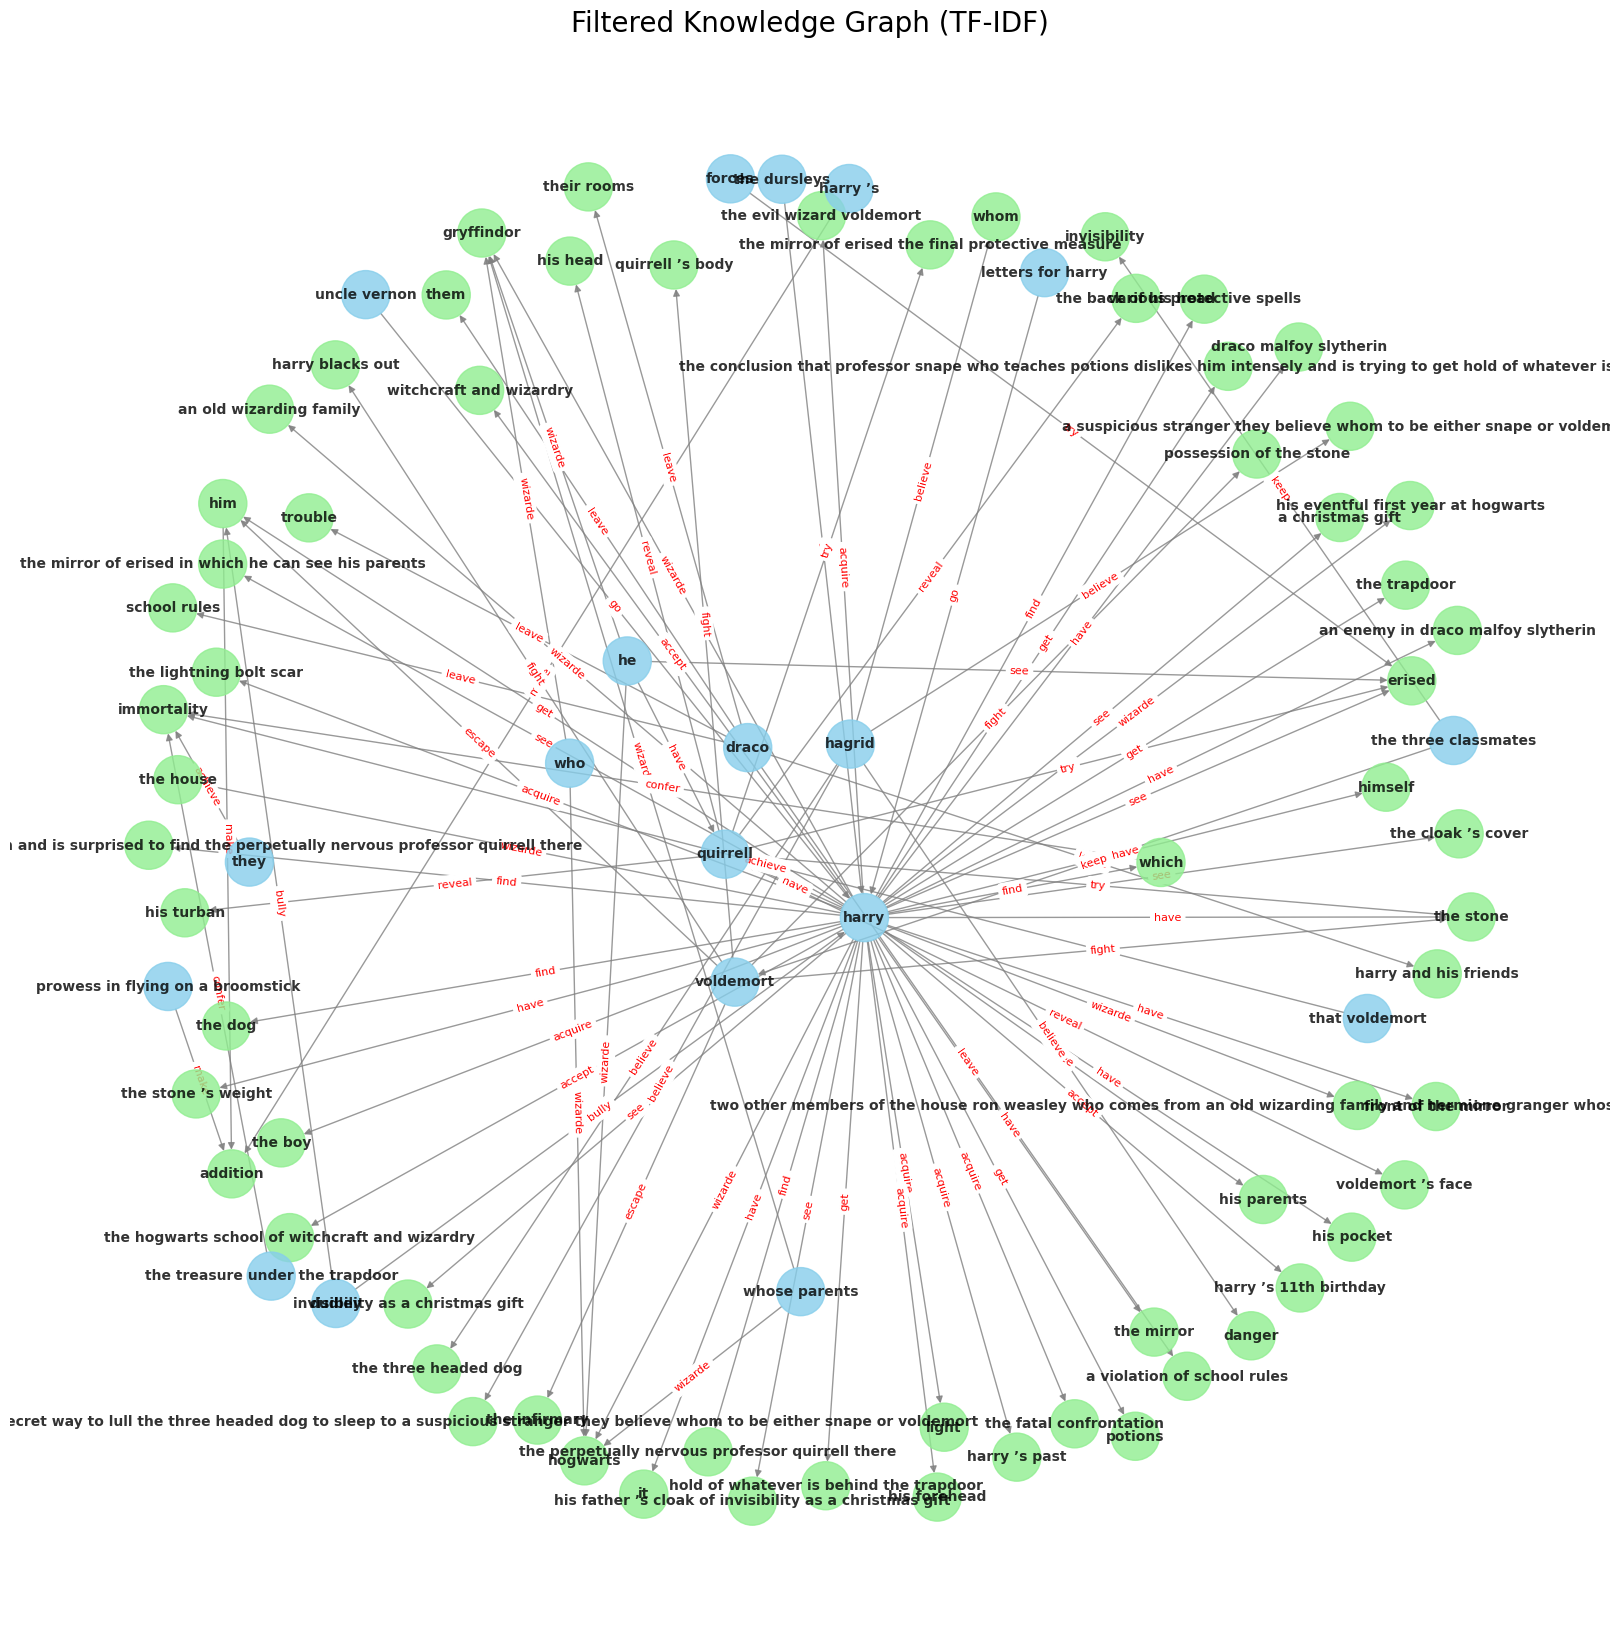

INFO:root:🔒 Neo4j driver closed.


In [4]:

logging.basicConfig(level=logging.INFO)

driver = None
try:
    driver = GraphDatabase.driver(uri, auth=(username, password))
    print("✅ Connected to Neo4j!")

    def close_driver():
        if driver:
            driver.close()
            logging.info("🔒 Neo4j driver closed.")

    def create_entity(tx, name: str):
        tx.run("MERGE (e:Entity {name: $name})", name=name)

    def create_relationship(tx, subj: str, pred: str, obj: str):
        tx.run("""
            MERGE (a:Entity {name: $subj})
            MERGE (b:Entity {name: $obj})
            MERGE (a)-[:RELATION {name: $pred}]->(b)
        """, subj=subj, pred=pred, obj=obj)

    # === Text Processing ===
    def load_and_clean_text(file_path: str) -> str:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        text = re.sub(r'\n+', ' ', text)
        return re.sub(r'\s+', ' ', text).strip().lower()

    # === TF-IDF Filtering ===
    def compute_tfidf_keywords(text: str, top_n=60):
        vectorizer = TfidfVectorizer(stop_words='english')
        X = vectorizer.fit_transform([text])
        scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return {word for word, _ in sorted_scores[:top_n]}

    # === Triple Extraction ===
    def get_full_phrase(token) -> str:
        return ' '.join(tok.text for tok in token.subtree if tok.dep_ != 'punct').strip()

    def extract_rich_triples(doc, tfidf_keywords) -> list:
        triples = []
        for sent in doc.sents:
            subjects = [tok for tok in sent if "subj" in tok.dep_]
            objects = [tok for tok in sent if "obj" in tok.dep_]
            verbs = [tok for tok in sent if tok.pos_ == "VERB"]
            for subj in subjects:
                for obj in objects:
                    for verb in verbs:
                        s = get_full_phrase(subj)
                        o = get_full_phrase(obj)
                        if s.lower() in tfidf_keywords or o.lower() in tfidf_keywords:
                            triples.append((s, verb.lemma_, o))
        return triples

    # === Graph Visualization ===
    def visualize_knowledge_graph(triples: list, title: str = "Knowledge Graph"):
        G = nx.DiGraph()
        for subj, pred, obj in triples:
            G.add_node(subj, label='Subject')
            G.add_node(obj, label='Object')
            G.add_edge(subj, obj, label=pred)

        pos = nx.spring_layout(G, k=1.2, seed=42)
        node_colors = ['skyblue' if G.nodes[n]['label'] == 'Subject' else 'lightgreen' for n in G.nodes]

        plt.figure(figsize=(16, 16))
        nx.draw(G, pos, with_labels=True, node_size=1200, node_color=node_colors,
                font_size=10, font_weight='bold', edge_color='gray', alpha=0.8)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)},
                                     font_size=8, font_color='red')
        plt.title(title, fontsize=20)
        plt.show()

    # === Main Execution ===
    file_path = r'C:\Users\jaiba\Desktop\KNOWLEDGE GRAPH\data2.txt'
    text = load_and_clean_text(file_path)
    tfidf_keywords = compute_tfidf_keywords(text)

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    triples = extract_rich_triples(doc, tfidf_keywords)
    logging.info(f"🧠 Extracted {len(triples)} filtered triples.")
    for t in triples[:10]:
        print("🔗", t)

    # === Push to Neo4j ===
    with driver.session() as session:
        for subj, pred, obj in triples:
            session.execute_write(create_entity, subj)
            session.execute_write(create_entity, obj)
            session.execute_write(create_relationship, subj, pred, obj)

    print("📡 Triples successfully stored in Neo4j.")

    # === Final Visualization ===
    visualize_knowledge_graph(triples, title="Filtered Knowledge Graph (TF-IDF)")

except Exception as e:
    logging.error(f"❌ An error occurred: {e}", exc_info=True)

finally:
    if driver:
        close_driver()
